In [1]:
# ntrain=1500

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter

import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial
import scipy.io as sio

from timeit import default_timer
from utilities3 import *

from Adam import Adam
from sklearn.metrics import r2_score
torch.manual_seed(0)
np.random.seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


## DATA LOADING

In [2]:
# mdata = sio.loadmat('/DATA1/meer/data/material-V2.mat')
# print(mdata.keys(),'\n')

# material = mdata['Emat']
# print('material shape, material type::==',material.shape,type(material))

# sdata = sio.loadmat('/DATA1/meer/data/stress_f5_123_3350.mat')
# print(sdata.keys(),'\n')

# stress = sdata['stresses']

# print(stress.shape)

# edata = sio.loadmat('/DATA1/meer/data/strain_f5_123_3350.mat')
# print(edata.keys(),'\n')

# strain = edata['strains']

# print(strain.shape)






### Helper f(x)

In [3]:
def toTensor(array):
    '''Converts a numpy array to a torch tensor.'''
    x = torch.from_numpy(array).type(torch.FloatTensor)
    x.requires_grad = True
    return x

def lossfunc(ytrue, ypred):
    batch = ytrue.shape[0]

    diff = torch.norm((ypred.reshape(batch,-1) - ytrue.reshape(batch,-1)), 2,1)
    ynorm  = torch.norm(ytrue.reshape(batch,-1), 2,1)
    
    err= torch.sum(diff/ynorm)
    
    return err

class UnitGaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(UnitGaussianNormalizer, self).__init__()

        # x could be in shape of ntrain*n or ntrain*T*n or ntrain*n*T
        self.mean = torch.mean(x, 0)
        self.std = torch.std(x, 0)
        self.eps = eps
        

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        if sample_idx is None:
            std = self.std + self.eps # n
            mean = self.mean
        else:
            if len(self.mean.shape) == len(sample_idx[0].shape):
                std = self.std[sample_idx] + self.eps  # batch*n
                mean = self.mean[sample_idx]
            if len(self.mean.shape) > len(sample_idx[0].shape):
                std = self.std[:,sample_idx]+ self.eps # T*batch*n
                mean = self.mean[:,sample_idx]

        # x is in shape of batch*n or T*batch*n
        x = (x * std) + mean
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()
        



#### MODEL-RESNET

In [12]:



class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        
        x = self.relu(self.batch_norm2(self.conv2(x)))
        
        x = self.conv3(x)
        x = self.batch_norm3(x)
        
        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)
        
        return x

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
       

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
        
        
        identity = x.clone()

        x = self.relu(self.batch_norm2(self.conv1(x)))
        x = self.batch_norm2(self.conv2(x))

        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        print(x.shape)
        print(identity.shape)
        x += identity
        x = self.relu(x)
        return x


        
        
class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)
        
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
            
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)

In [7]:
def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)

In [19]:


################################################################
# configs
################################################################


pathm_5 = '/DATA1/meer/data/material-v3-3350.mat'

pathe_5 = '/DATA1/meer/data/strain-v3-3350.mat'
TRAIN_PATH = pathm_5#'material.mat'
# TEST_PATH = '/content/drive/MyDrive/traj/E22-frame5.mat'
TEST_PATH = pathe_5#'StressStrainData/strainsv2.mat'
# TEST_PATH = '/content/drive/MyDrive/traj/fieldvars-frame5.mat'

ntrain =1200
ntest = 200

batch_size =20


################################################################
# load data and data normalization
################################################################
reader = MatReader(TRAIN_PATH)   ### X of train and test
x_train = reader.read_field('Emat')[:ntrain]#,::r,::r][:,:s,:s]   #####[samples,48,48,1]
x_test = reader.read_field('Emat')[-ntest:]# ,::r,::r][:,:s,:s]     #####[samples,48,48,1]
x_test_plot = reader.read_field('Emat')[-ntest:]


reader.load_file(TEST_PATH)  # y data for train and test

# y_train = reader.read_field('E22')[:2*ntrain:2]#     ######[samples,48,48,6]
# y_test = reader.read_field('E22')[2*ntrain:2*ntrain+3*ntest:3] 

y_train = reader.read_field('strain')[:ntrain]#     ######[samples,48,48,6]
y_test_strain = reader.read_field('strain')[-ntest:]    ############[samples,48,48,6]

x_normalizer = UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)

y_normalizer = UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)



train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test_strain), batch_size=batch_size, shuffle=False)



if device=='cpu':
    y_normalizer.cpu()
else:
    y_normalizer.cuda()


In [20]:
model = ResNet50(48*48*3, 1).to(device)
print(f'MODEL PARAMETERS. :== {count_params(model)}')
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay= 1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)  ### gamma =0.1
epochs = 500
print('\n')
      
print(f'Epochs:= {epochs}--- LR:={learning_rate}---BatchSize:= {batch_size}')

MODEL PARAMETERS. :== 37690944


Epochs:= 500--- LR:=0.001---BatchSize:= 20


In [21]:

trainerror=[] 
testerror=[]
dim =s
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        x =x.reshape(x.shape[0], 1, dim, dim)

        optimizer.zero_grad()

        out = model(x).reshape(batch_size, dim, dim,3)

        out = y_normalizer.decode(out)
        y = y_normalizer.decode(y)
        
        

        loss = lossfunc(y.view(batch_size,-1),out.view(batch_size,-1))
  
        loss.backward()

        optimizer.step()
        train_l2 += loss.item()

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            x =x.reshape(x.shape[0], 1, dim, dim)
            out = model(x).reshape(batch_size, dim, dim,3)
            out = y_normalizer.decode(out)

            test_l2 += lossfunc(y.view(batch_size,-1),out.view(batch_size,-1)).item()

    train_l2/= ntrain
    test_l2 /= ntest
    trainerror += [train_l2]
    testerror += [test_l2]
    t2 = default_timer()
    print(f' Epoch :== {ep+1}  ||  TIME(sec):== {np.round((t2-t1),4)} '
          f'|| TrainError:== {np.round(train_l2,6)}  ||  TestError:== {np.round(test_l2,6)}')

 Epoch :== 1  ||  TIME(sec):== 8.6409 || TrainError:== 0.750816  ||  TestError:== 0.773389
 Epoch :== 2  ||  TIME(sec):== 4.1863 || TrainError:== 0.711405  ||  TestError:== 0.709424
 Epoch :== 3  ||  TIME(sec):== 4.3844 || TrainError:== 0.702428  ||  TestError:== 0.693787
 Epoch :== 4  ||  TIME(sec):== 4.4271 || TrainError:== 0.689473  ||  TestError:== 0.726322
 Epoch :== 5  ||  TIME(sec):== 4.4421 || TrainError:== 0.66998  ||  TestError:== 0.645172
 Epoch :== 6  ||  TIME(sec):== 4.4247 || TrainError:== 0.624841  ||  TestError:== 0.601145
 Epoch :== 7  ||  TIME(sec):== 4.4317 || TrainError:== 0.586718  ||  TestError:== 0.841473
 Epoch :== 8  ||  TIME(sec):== 4.3889 || TrainError:== 0.554969  ||  TestError:== 1.449655
 Epoch :== 9  ||  TIME(sec):== 4.3295 || TrainError:== 0.518996  ||  TestError:== 0.524123
 Epoch :== 10  ||  TIME(sec):== 4.409 || TrainError:== 0.483071  ||  TestError:== 0.505731
 Epoch :== 11  ||  TIME(sec):== 4.3891 || TrainError:== 0.445098  ||  TestError:== 0.441798

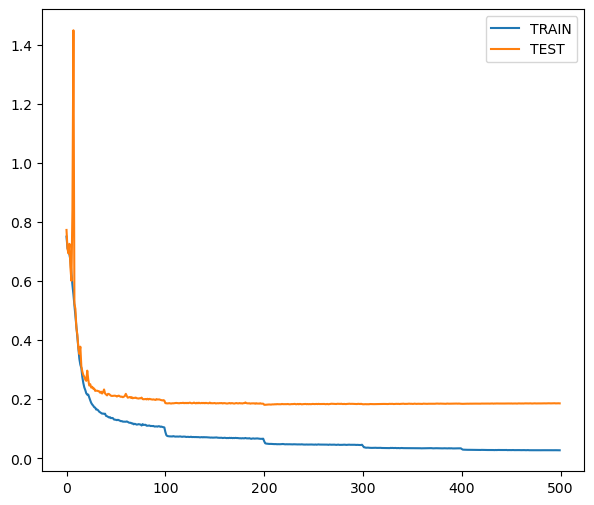

In [22]:
plt.figure(figsize=(7,6))
plt.plot(range(epochs),trainerror, label ="TRAIN")
plt.plot(range(epochs),testerror, label ="TEST")
plt.legend()
plt.show()

In [23]:
trainn = np.array(trainerror)
testnn = np.array(testerror)
torch.save(model.state_dict(),'ResNet_STAIN_N1200_ep1200.pt')
np.save('trainResNet_STRAIN', trainn)
np.save('testResNet_STRAIN', testnn)

In [24]:
prediction = torch.zeros(y_test_strain.shape)
c = 0
with torch.no_grad():
    for x,y in test_loader:
        x, y = x.to(device), y.to(device)
        x =x.reshape(x.shape[0], 1, dim, dim)
        out = model(x).reshape(batch_size, dim, dim,3)
        out = y_normalizer.decode(out)
        prediction[c*batch_size :c*batch_size+batch_size] = out
        c+=1
        
        

In [25]:
strain_act = y_test_strain.reshape(ntest, -1)
strain_pred = prediction.reshape(ntest,-1)



In [26]:
r2_strain =[]
for i in range(strain_act.shape[0]):
    act = strain_act[i]
    pred = strain_pred[i]

    r2 = r2_score(act,pred)

    r2_strain += [r2]

In [27]:
r2_avg_strain = np.average(r2_strain)
r2_std_strain = np.std(r2_strain)

print(r2_avg_strain,r2_std_strain)

0.9580022353265761 0.03200285757707555


/home/user/anaconda3/envs/mehran/lib/python3.10/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/user/anaconda3/envs/mehran/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


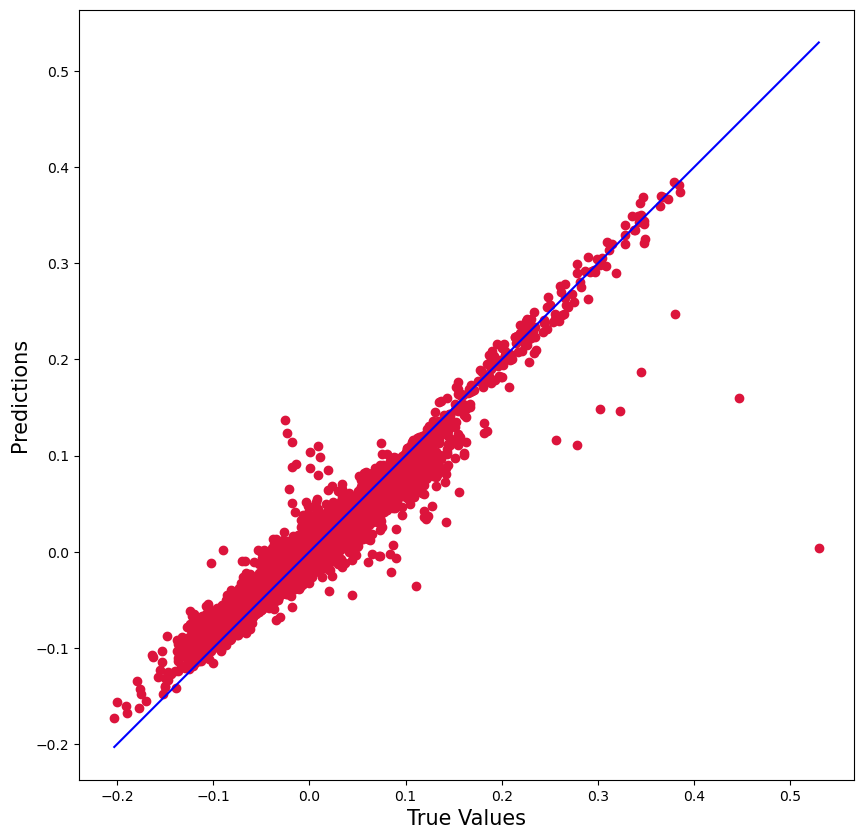

In [28]:
plt.figure(figsize=(10,10))
plt.scatter(y_test_strain.reshape(-1,1), prediction, c='crimson')
# plt.yscale('log')
# plt.xscale('log')

p1 = max(max(prediction.reshape(-1,1)), max(y_test_strain.reshape(-1,1)))
p2 = min(min(prediction.reshape(-1,1)), min(y_test_strain.reshape(-1,1)))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [31]:
strain_act = y_test_strain.reshape(ntest, -1)
strain_pred = prediction.reshape(ntest,-1)

r2_strain =[]
for i in range(strain_act.shape[0]):
    act = strain_act[i]
    pred = strain_pred[i]
    r2 = r2_score(act,pred)
    r2_strain += [r2]

In [32]:
r2_avg_strain = np.average(r2_strain)
r2_std_strain = np.std(r2_strain)

print(r2_avg_strain,r2_std_strain)

0.9580022353265761 0.03200285757707555


In [33]:
loss = lossfunc(y_test_strain, prediction)
print(loss/ntest)

tensor(0.1860)


In [23]:
print(np.round(np.array([0.9580022353265761]),2))
print(np.round(np.array([0.03200285757707555]),2))

[0.96]
[0.03]


## STRESS

In [8]:


################################################################
# configs
################################################################


pathm_5 = '/DATA1/meer/data/material-v3-3350.mat'

pathe_5 = '/DATA1/meer/data/stress-v3-3350.mat'
TRAIN_PATH = pathm_5#'material.mat'
# TEST_PATH = '/content/drive/MyDrive/traj/E22-frame5.mat'
TEST_PATH = pathe_5#'StressStrainData/strainsv2.mat'
# TEST_PATH = '/content/drive/MyDrive/traj/fieldvars-frame5.mat'

ntrain =1200
ntest = 200


batch_size =20
################################################################
# load data and data normalization
################################################################
reader = MatReader(TRAIN_PATH)   ### X of train and test
x_train = reader.read_field('Emat')[:ntrain]#,::r,::r][:,:s,:s]   #####[samples,48,48,1]
x_test = reader.read_field('Emat')[-ntest:]# ,::r,::r][:,:s,:s]     #####[samples,48,48,1]
x_test_plot = reader.read_field('Emat')[-ntest:]


reader.load_file(TEST_PATH)  # y data for train and test

# y_train = reader.read_field('E22')[:2*ntrain:2]#     ######[samples,48,48,6]
# y_test = reader.read_field('E22')[2*ntrain:2*ntrain+3*ntest:3] 

y_train = reader.read_field('stress')[:ntrain]#     ######[samples,48,48,6]
y_test_stress = reader.read_field('stress')[-ntest:]    ############[samples,48,48,6]

x_normalizer = UnitGaussianNormalizer(x_train)
x_train = x_normalizer.encode(x_train)
x_test = x_normalizer.encode(x_test)

y_normalizer = UnitGaussianNormalizer(y_train)
y_train = y_normalizer.encode(y_train)


train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test_stress), batch_size=batch_size, shuffle=False)



if device=='cpu':
    y_normalizer.cpu()
else:
    y_normalizer.cuda()


In [13]:
def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)

In [14]:
model = ResNet50(48*48*3, 1).to(device)
print(f'MODEL PARAMETERS. :== {count_params(model)}')
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay= 1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)  ### gamma =0.1
epochs = 500
print('\n')
      
print(f'Epochs:= {epochs}--- LR:={learning_rate}---BatchSize:= {batch_size}')

MODEL PARAMETERS. :== 37690944


Epochs:= 500--- LR:=0.001---BatchSize:= 20


In [16]:

trainerror=[] 
testerror=[]
dim =48
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        x =x.reshape(x.shape[0], 1, dim, dim)

        optimizer.zero_grad()

        out = model(x).reshape(batch_size, dim, dim,3)

        out = y_normalizer.decode(out)
        y = y_normalizer.decode(y)
        
        

        loss = lossfunc(y.view(batch_size,-1),out.view(batch_size,-1))
  
        loss.backward()

        optimizer.step()
        train_l2 += loss.item()

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            x =x.reshape(x.shape[0], 1, dim, dim)
            out = model(x).reshape(batch_size, dim, dim,3)
            out = y_normalizer.decode(out)

            test_l2 += lossfunc(y.view(batch_size,-1),out.view(batch_size,-1)).item()

    train_l2/= ntrain
    test_l2 /= ntest
    trainerror += [train_l2]
    testerror += [test_l2]
    t2 = default_timer()
    print(f' Epoch :== {ep+1}  ||  TIME(sec):== {np.round((t2-t1),4)} '
          f'|| TrainError:== {np.round(train_l2,6)}  ||  TestError:== {np.round(test_l2,6)}')

 Epoch :== 1  ||  TIME(sec):== 5.2223 || TrainError:== 0.561322  ||  TestError:== 0.530351
 Epoch :== 2  ||  TIME(sec):== 2.7418 || TrainError:== 0.527983  ||  TestError:== 0.532005
 Epoch :== 3  ||  TIME(sec):== 2.7662 || TrainError:== 0.519814  ||  TestError:== 0.52127
 Epoch :== 4  ||  TIME(sec):== 2.8277 || TrainError:== 0.510684  ||  TestError:== 0.508608
 Epoch :== 5  ||  TIME(sec):== 2.8241 || TrainError:== 0.484083  ||  TestError:== 0.485042
 Epoch :== 6  ||  TIME(sec):== 2.772 || TrainError:== 0.440593  ||  TestError:== 0.613209
 Epoch :== 7  ||  TIME(sec):== 2.7667 || TrainError:== 0.404392  ||  TestError:== 0.400052
 Epoch :== 8  ||  TIME(sec):== 2.7531 || TrainError:== 0.366068  ||  TestError:== 0.359904
 Epoch :== 9  ||  TIME(sec):== 2.7625 || TrainError:== 0.336875  ||  TestError:== 0.347915
 Epoch :== 10  ||  TIME(sec):== 2.7532 || TrainError:== 0.319813  ||  TestError:== 0.316096
 Epoch :== 11  ||  TIME(sec):== 2.7507 || TrainError:== 0.30205  ||  TestError:== 0.312002


In [17]:
trainn = np.array(trainerror)
testnn = np.array(testerror)
torch.save(model.state_dict(),'ResNet_STRESS_N1200_ep1200.pt')
np.save('trainResNetStress', trainn)
np.save('testResNetStress', testnn)

In [28]:
prediction = torch.zeros(y_test_stress.shape)
c = 0
with torch.no_grad():
    for x,y in test_loader:
        x, y = x.to(device), y.to(device)
        x =x.reshape(x.shape[0], 1, dim, dim)
        
        out = model(x).reshape(batch_size, dim, dim,3)
        out = y_normalizer.decode(out)
        prediction[c*batch_size :c*batch_size+batch_size] = out
        c+=1
        
        

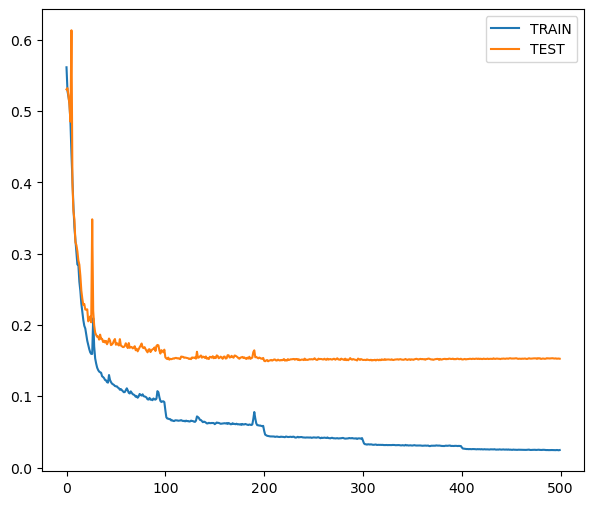

In [29]:
plt.figure(figsize=(7,6))
plt.plot(range(epochs),trainerror, label ="TRAIN")
plt.plot(range(epochs),testerror, label ="TEST")
plt.legend()
plt.show()

In [30]:
stress_act = y_test_stress.reshape(ntest, -1)
stress_pred = prediction.reshape(ntest,-1)

r2_stress =[]
for i in range(stress_act.shape[0]):
    act = stress_act[i]
    pred = stress_pred[i]
    r2 = r2_score(act,pred)
    r2_stress += [r2]

In [31]:
r2_avg_stress = np.average(r2_stress)
r2_std_stress = np.std(r2_stress)

print(r2_avg_stress,r2_std_stress)

0.9558717216300522 0.06735183573501285


In [32]:
loss = lossfunc(y_test_stress, prediction)
print(loss/ntest)

tensor(0.1526)


In [33]:
print(np.round(np.array([0.9558717216300522]),2))
print(np.round(np.array([0.06735183573501285]),2))

[0.96]
[0.07]


In [40]:
loss = lossfunc( y_test_stress.reshape(ntest,-1),prediction.reshape(ntest,-1))

In [41]:
print(loss/ntest)

tensor(0.1526)


In [34]:
myloss = LpLoss(size_average=True)

In [36]:
loss = myloss(prediction.reshape(ntest,-1), y_test_stress.reshape(ntest,-1))
print(loss)

tensor(0.1526)


In [145]:
# loss = myloss(prediction.reshape(ntest,-1), y_test_stress.reshape(ntest,-1))
# print(loss/ntest)

tensor(0.1423)


In [150]:
# loss = lossfunc(y_test_stress.reshape(ntest,-1),prediction.reshape(ntest,-1))
# print(loss/ntest)

tensor(0.1423)
